# Multiclass Balancing

Imbalanced datasets may often produce poor performance when running a Machine Learning model, although, in some cases the evaluation metrics produce good results. This can be due to the fact that the model is good at predicting the majority class but it has poor performance predicting the minority class. Since the evaluation metrics calculate the average value between the majority and the minority classes, the final performance would seems fine.

By majority class, I mean the most represented class in the dataset, while by minority class, I mean the less represented class in the dataset. In other words, for the majority class there are more samples then the minority class. In this case, the dataset is imbalanced

In most cases balancing improves the model performance, although it is not always true.

In this tutorial, I deal with multiclass datasets. A multiclass dataset is a dataset where the number of output classes is greater than two. I propose two strategies to balance a multiclass dataset:
* pipeline undersampling and oversampling
* play with class weights


## Glass dataset

The details of the glass dataset can be found [here](https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.names)

The dataset describes the chemical properties of glass. 

More details [here](https://machinelearningmastery.com/multi-class-imbalanced-classification/)

Summary:
1. Id number: 1 to 214
2. RI: refractive index
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
7. K: Potassium
8. Ca: Calcium
9. Ba: Barium
10. Fe: Iron
11. Type of glass: (class attribute)
    * 1 building_windows_float_processed
    * 2 building_windows_non_float_processed
    * 3 vehicle_windows_float_processed
    * 4 vehicle_windows_non_float_processed (none in this database)
    * 5 containers
    * 6 tableware
    * 7 headlamps

In [1]:
import pandas as pd

df = pd.read_csv('glass.csv')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,target
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df.shape

(214, 10)

In [5]:
df.target.unique()

array([1, 2, 3, 5, 6, 7])

The dataset has 214 samples and 6 classes

## Prepare data

I build two variables, `X` and `y` containing the input features and the output classes, respectively. In order to do so, I calculate the input features and I store them into a variable called `features`

In [6]:
features = []
for feature in df.columns:
    if feature != 'target':
        features.append(feature)
        
features

['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

In [7]:
X = df[features]
y = df['target']

I split the dataset into two parts: training and test sets by using the `train_test_split()`.</br>
Test size is set to 0.2, 20% of the dataset

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

Now, calculate the number of samples for each target class in the training set. </br>
The dataset is imbalanced. Balancing is <strong>only</strong> applied to the <strong>training</strong> set

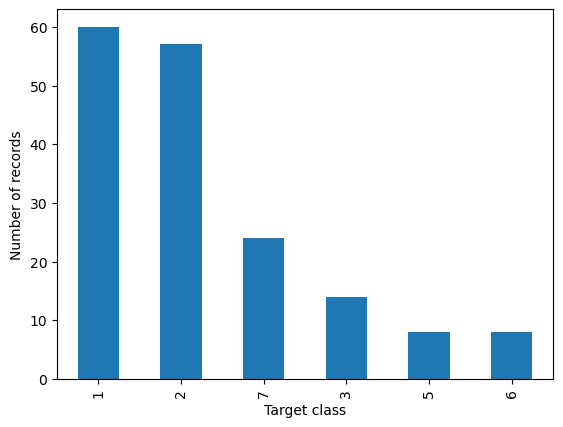

In [10]:
import matplotlib.pyplot as plt

count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target class')
plt.show()

## Build the imbalanced model

Before balancing the training set, calculate the performance of the model with imbalanced dataset. `KNeighborsClassifier` would be applied to the training set.

The performance of the model would be calcualted through the `predict_proba()` function on the test set

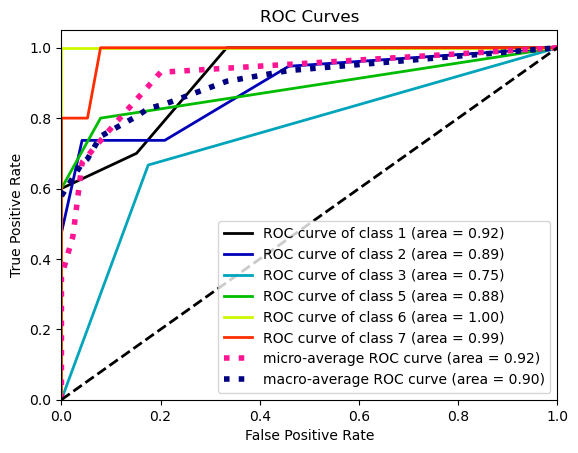

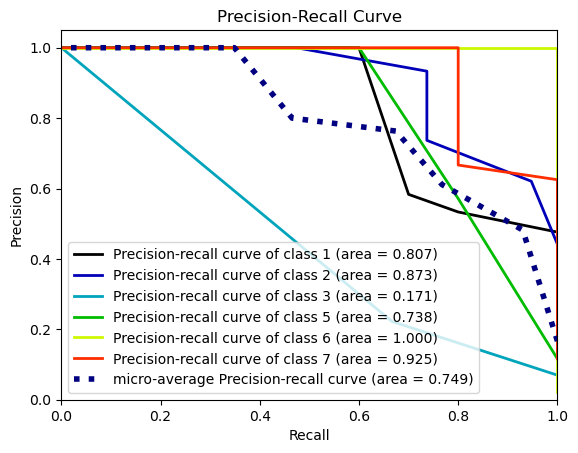

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_roc, plot_precision_recall

model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Plot metrics
plot_roc(y_test, y_score)
plt.show()

plot_precision_recall(y_test, y_score)
plt.show()

## Pipeline undersampling and oversampling

The first strategy involves the creation of a pipeline, which undersamples the majority classes and oversamples the minority classes. The point here is to define a threshold which splits majority and minority classes, as well as the number of desired samples for each class. In this example, we set the threshold to be equal to the number of desired samples for each class.

One possible solution could be to set the threshold to the median value of the number of samples in the classes. Thus I can set the threshold to 19 and consider a majority class with a number of samples greater than the threshold. Similarly, a minority class is a class with the number of samples less than the threshold.

The median is calculated and converted to integer.

In [18]:
import numpy as np

n_samples = int(count.median())
n_samples

19

Now, undersample the majority class.</br>
First, suppress warnings

In [19]:
import warnings
warnings.filterwarnings('ignore')

Then, define a utility function, which receives as input the dataset, the threshold (`n_samples`) and the involved classes (`majority` or `minority`). This function returns a `dict` which contains the number of desired samples for each class belonging to the involved classes.

In [34]:
def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
        
    tc = target_classes[target_classes == True].index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

Now perform undersampling of the majority classes

In [35]:
from imblearn.under_sampling import ClusterCentroids
under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train, y_train, n_samples,t='majority'))
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

The number of records in the majority classes have been set to `n_samples`

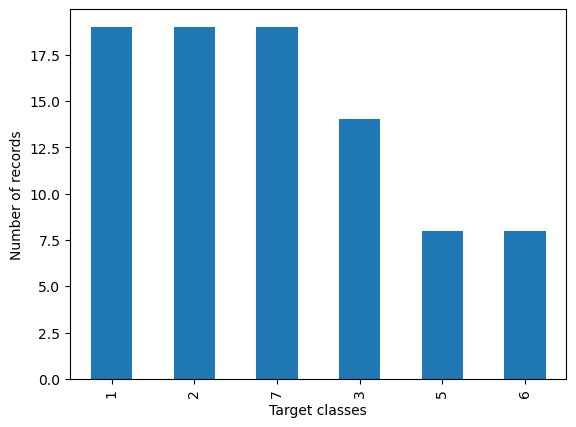

In [37]:
count = y_under.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target classes')
plt.show()

Then oversample the minority classes

In [38]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under, n_samples, t='minority'), k_neighbors=2)
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

Eventually, a balanced dataset

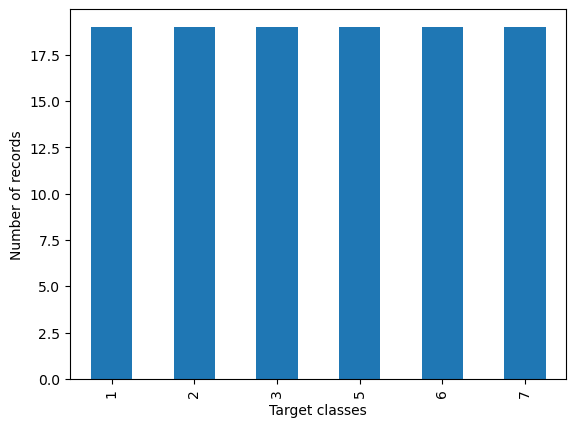

In [39]:
count = y_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target classes')
plt.show()

## Train the model with the balances dataset

The ROC curve improves, while the precision recall curve seems to decrease. However, looking at the class 3, in the original model, the precision and recall were lower than in the balanced model. This means that the model is now able to predict better the minority classes.

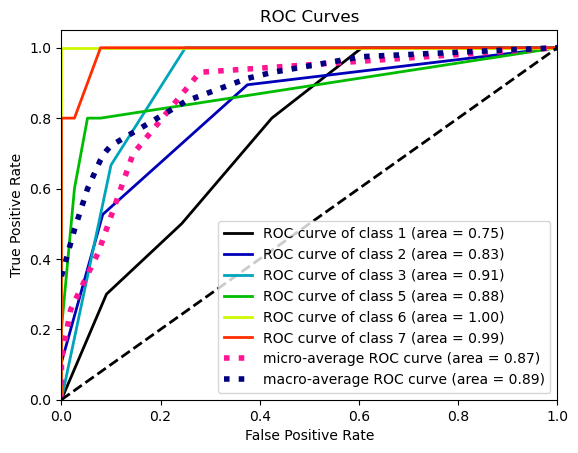

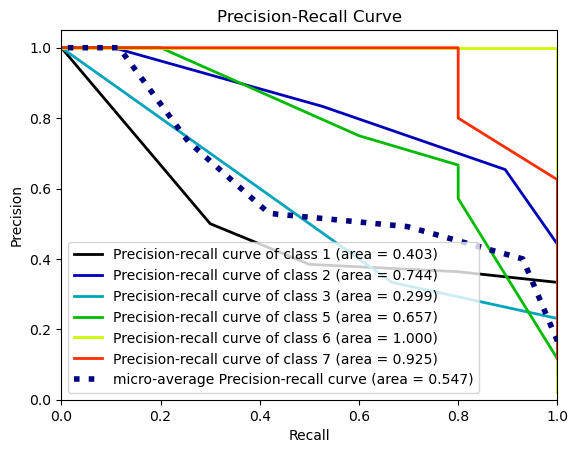

In [41]:
model = KNeighborsClassifier()
model.fit(X_bal, y_bal)
y_score = model.predict_proba(X_test)

y_pred = model.predict(X_test)

plot_roc(y_test, y_score)
plt.show()

plot_precision_recall(y_test, y_score)
plt.show()

## Play with class weights

An alternative to balancing is to specify the class weights in the original dataset while building the model. This permits the algorithm to give more importance to minority classes. Class weights can be calculated through `compute_class_weight()` function in the `sklearn.utils` library

In [43]:
from sklearn.utils import class_weight

classes = np.unique(y_train)
cw = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
weights = dict(zip(classes, cw))

Provide the weights as an input to a classifier

In [44]:
weights

{1: 0.475, 2: 0.5, 3: 2.0357142857142856, 5: 3.5625, 6: 3.5625, 7: 1.1875}

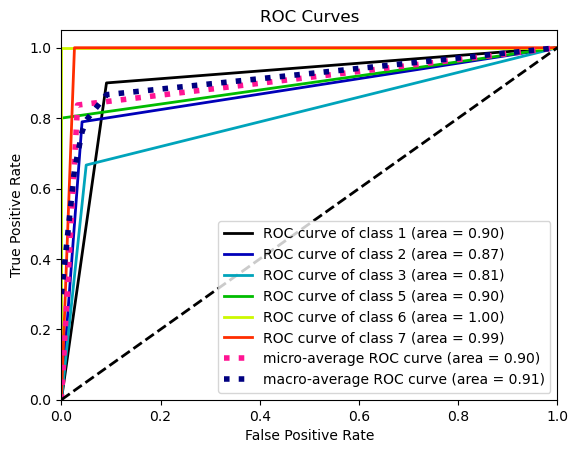

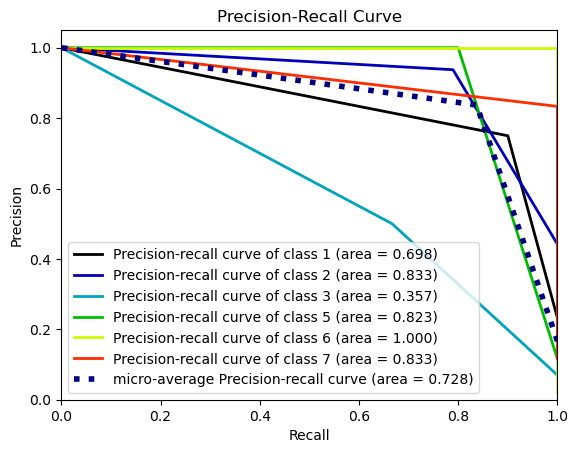

In [46]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(class_weight=weights)
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)

y_pred = model.predict(X_test)

plot_roc(y_test, y_score)
plt.show()

plot_precision_recall(y_test, y_score)
plt.show()

In [47]:
y_score

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0.

In [48]:
y_pred

array([2, 7, 1, 2, 2, 2, 3, 1, 6, 2, 2, 5, 7, 2, 2, 1, 5, 1, 1, 3, 5, 7,
       2, 7, 2, 1, 7, 1, 2, 1, 2, 2, 1, 1, 1, 7, 3, 1, 2, 2, 3, 5, 2])